In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from termcolor import colored

face_cascade = cv2.CascadeClassifier('/home/mckc/Downloads/opencv-2.4.13/data/haarcascades_GPU/haarcascade_frontalface_default.xml')

In [2]:
#Reading the image data into numpy
def rgb2gray(rgb):
    return np.dot(rgb[:,:,:], [0.299, 0.587, 0.114])

def load_data():
    import pandas as pd
    import numpy as np
    from PIL import Image
    
    train = pd.read_csv('/home/mckc/Images/train.csv')
    test = pd.read_csv('/home/mckc/Images/test.csv')
    print 'the training data shape is ',train.shape
    print 'the test data shape is ', test.shape
    
    X_tr = np.zeros((1,1944,2592),dtype=np.uint8)
    for i in train.values[:,0]:
        image = rgb2gray(np.array(Image.open(i))).astype(np.uint8).reshape(1,1944,2592)
#     print X_tr.shape,image.shape
        X_tr =  np.vstack((X_tr,image))
    Y_tr = train.values[:,1]
    X_tr = X_tr[1:,:,:]
    X_ts = np.zeros((1,1944,2592),dtype=np.uint8)
    for i in test.values[:,0]:
        image = rgb2gray(np.array(Image.open(i))).astype(np.uint8).reshape(1,1944,2592)
        X_ts = np.vstack((X_ts,image))
    Y_ts = test.values[:,1]
    X_ts = X_ts[1:,:,:]
    print 'the training file shape',X_tr.shape,Y_tr.shape
    print 'the testing file shape',X_ts.shape,Y_ts.shape
    
    return X_tr,X_ts,Y_tr,Y_ts    

In [3]:
def extract_faces(X_tr,Y_tr):
    from skimage.transform import resize
    import time
    start_time = time.clock()
    all_faces = np.zeros((1,96,96),dtype=np.uint8)
    missing = []
    multiple = []
    Y= []
    for i in range(len(X_tr)):
        faces  = face_cascade.detectMultiScale(X_tr[i,:,:],scaleFactor=1.3,minNeighbors=5,minSize=(70, 70))
        n_faces = len(faces)
        if n_faces is 1:
            for (x,y,w,h) in faces:
                fac = np.array(X_tr[i,:,:])[y:(y+h),x:(x+h)]
                out = (resize(fac,(96,96))).reshape((1,96,96))
                all_faces = np.vstack((all_faces,out))
                Y = np.append(Y,Y_tr[i])
        else:
            if n_faces > 1:
                #print ('There are multiple faces for index %d and with length %d' % (i , n_faces))
                missing = np.append(missing,i)
                #all_faces = np.vstack((all_faces,np.zeros((1,96,96),dtype=np.uint8)))
            else:
                #print ('The face is missing for index %d' %i)
                multiple = np.append(multiple,i)
        if i % 50==0:
            print colored((float(i)/len(X_tr)*100 ,' Percentage complete'), 'green')

    all_faces = all_faces[1:,:,:]
    print all_faces.shape
    print time.clock() - start_time, "seconds"
    return all_faces,missing,multiple,Y

In [4]:
def simulate(X,Y):
    import scipy as sp
    import scipy.ndimage
    complete = np.zeros((1,96,96),dtype=np.uint8)
    Y_complete = []
    for i in range(len(X)):
        complete = np.vstack((complete,X[i,:,:].reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(X[i,:,:], angle = 5,reshape=False,cval=1).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(X[i,:,:], angle = 10,reshape=False,cval=1).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(X[i,:,:], angle = 15,reshape=False,cval=1).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(X[i,:,:], angle = -5,reshape=False,cval=1).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(X[i,:,:], angle = -15,reshape=False,cval=1).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(X[i,:,:], angle = -10,reshape=False,cval=1).reshape(1,96,96)))
        rotated = np.fliplr(X[i,:,:])
        complete = np.vstack((complete,scipy.ndimage.rotate(rotated, angle = 5,reshape=False,cval=1).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(rotated, angle = 10,reshape=False,cval=1).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(rotated, angle = 15,reshape=False,cval=1).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(rotated, angle = -5,reshape=False,cval=1).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(rotated, angle = -10,reshape=False,cval=1).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(rotated, angle = -15,reshape=False,cval=1).reshape(1,96,96)))
        complete = np.vstack((complete,rotated.reshape(1,96,96)))
        Y_complete = np.append(Y_complete,([Y[i]]*14))
        if i % 10==0:
            print colored((float(i)/len(X)*100 ,' Percentage complete'),'green')
    complete = complete[1:,:,:]
    return complete,Y_complete

In [7]:
X_tr,X_tst,Y_tr,Y_tst = load_data()

the training data shape is  (152, 2)
the test data shape is  (51, 2)
the training file shape (152, 1944, 2592) (152,)
the testing file shape (51, 1944, 2592) (51,)


In [8]:
X_train,missing,multiple,Y_train = extract_faces(X_tr[:,:,:],Y_tr)
X_test,missing_test,multiple_test,Y_test = extract_faces(X_tst,Y_tst)

(0.0, ' Percentage complete')
(32.89473684210527, ' Percentage complete')
(65.78947368421053, ' Percentage complete')
(98.68421052631578, ' Percentage complete')
(131, 96, 96)
121.555834 seconds
(0.0, ' Percentage complete')
(98.0392156862745, ' Percentage complete')
(44, 96, 96)
41.464159 seconds


In [9]:
import time
start_time = time.clock()
X,Y = simulate(X_train,Y_train)
print X.shape,Y.shape
print time.clock() - start_time, "seconds"

(0.0, ' Percentage complete')
(7.633587786259542, ' Percentage complete')
(15.267175572519085, ' Percentage complete')
(22.900763358778626, ' Percentage complete')
(30.53435114503817, ' Percentage complete')
(38.16793893129771, ' Percentage complete')
(45.80152671755725, ' Percentage complete')
(53.43511450381679, ' Percentage complete')
(61.06870229007634, ' Percentage complete')
(68.70229007633588, ' Percentage complete')
(76.33587786259542, ' Percentage complete')
(83.96946564885496, ' Percentage complete')
(91.6030534351145, ' Percentage complete')
(99.23664122137404, ' Percentage complete')
(1834, 96, 96) (1834,)
19.750267 seconds


In [11]:
def standard(X):
    return (X - X.mean())/X.max()

In [12]:
X_test = standard(X_test)
X = standard(X)

In [13]:
X_normal = X.reshape(-1,9216)
X_test_normal = X_test.reshape(-1,9216)
map, Y_number = np.unique(Y, return_inverse=True)
Y_test_numer = np.unique(Y_test, return_inverse=True)[1]

In [14]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(verbose=1,n_jobs=-1)
clf.fit(X_normal,Y_number)
Y_logictic= clf.predict(X_test.reshape(-1,9216))

[LibLinear]

In [15]:
from sklearn.ensemble import RandomForestClassifier
recognizer = RandomForestClassifier(500,verbose=1,oob_score=True,n_jobs=5)
recognizer.fit(X_normal,Y_number)

[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done 500 out of 500 | elapsed:    4.2s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=5,
            oob_score=True, random_state=None, verbose=1, warm_start=False)

In [ ]:
import lasagne
#from lasagne.layers.cuda_convnet import Conv2DCCLayer as Conv2DLayer
#from lasagne.layers.cuda_convnet import MaxPool2DCCLayer as MaxPool2DLayer
from lasagne import layers
from lasagne.objectives import categorical_crossentropy
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import BatchIterator,visualize,NeuralNet
Conv2DLayer = layers.Conv2DLayer
MaxPool2DLayer = layers.MaxPool2DLayer

net = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', Conv2DLayer),
        ('pool1', MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),
        ('conv2', Conv2DLayer),
        ('pool2', MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),
        ('conv3', Conv2DLayer),
        ('pool3', MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    dropout1_p=0.1,
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    dropout2_p=0.2,
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    dropout3_p=0.3,
    hidden4_num_units=1000,
    dropout4_p=0.5,
    hidden5_num_units=1000,
    output_nonlinearity=lasagne.nonlinearities.softmax,
    output_num_units=2,
    
    update = nesterov_momentum,
    update_learning_rate=0.001,
    update_momentum=0.9,
    max_epochs=20,
    verbose=1
)
net.fit(X.reshape(-1,1,96,96).astype(np.float32), Y_number.astype(np.uint8))

# Neural Network with 16533474 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    2

  epoch    trn loss    val loss    trn/val    valid acc  dur
-------  ----------  ----------  ---------  -----------  ------
      1     0.68892     0.68880    1.00016      0.56522  40.07s


In [ ]:
%%capture
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import backend as K
from keras.optimizers import Adam,SGD
from keras.utils import np_utils


Y_Keras = np_utils.to_categorical(Y_number, 2)
# Create first network with Keras
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
model = Sequential()
model.add(Dense(1000, input_dim=9216,activation='relu'))
model.add(Dense(2,activation='softmax'))
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

import time
model.fit(X.reshape(-1,9216), Y_Keras, nb_epoch=10, batch_size=5,verbose=1,
         validation_data=(X_test.reshape(-1,9216), np_utils.to_categorical(Y_test_numer, 2)))

In [ ]:
jpgfile = Image.open("/home/mckc/Downloads/1.jpg")
grey = rgb2gray(np.array(jpgfile))
faces  = face_cascade.detectMultiScale(grey.astype(np.uint8),scaleFactor=1.1,minNeighbors=3,minSize=(30, 30))
print faces


for (x,y,w,h) in faces:
    fac = np.array(grey[y:(y+h),x:(x+h)])
    out = resize(fac,(96,96))
    
plt.imshow(out,cmap=cm.Greys_r)

from sklearn.ensemble import RandomForestClassifier
recognizer = RandomForestClassifier(500,verbose=0,oob_score=True,n_jobs=5)
recognizer.fit(X_normal,Y_number)

trial = out.astype(np.float64)
print 'Linear Regression Value',map[clf.predict(trial.reshape(-1,9216))]
print 'Random Forest Value',map[recognizer.predict(trial.reshape(-1,9216))]
print 'Lasagne Value',map[recognizer.predict(trial.reshape(-1,1,96,96))]
print 'Keras Value',map[recognizer.predict(trial.reshape(-1,1,96,96))]

In [ ]:
jpgfile = Image.open("/home/mckc/Downloads/2.jpg")
grey = rgb2gray(np.array(jpgfile))
faces  = face_cascade.detectMultiScale(grey.astype(np.uint8),scaleFactor=1.1,minNeighbors=3,minSize=(30, 30))
print faces


for (x,y,w,h) in faces:
    fac = np.array(grey[y:(y+h),x:(x+h)])
    out = resize(fac,(96,96))
    
plt.imshow(out,cmap=cm.Greys_r)

from sklearn.ensemble import RandomForestClassifier
recognizer = RandomForestClassifier(500,verbose=0,oob_score=True,n_jobs=5)
recognizer.fit(X_normal,Y_number)

trial = out.astype(np.float64)
print 'Linear Regression Value',map[clf.predict(trial.reshape(-1,9216))]
print 'Random Forest Value',map[recognizer.predict(trial.reshape(-1,9216))]
print 'Lasagne Value',map[recognizer.predict(trial.reshape(-1,1,96,96))]
print 'Keras Value',map[recognizer.predict(trial.reshape(-1,1,96,96))]

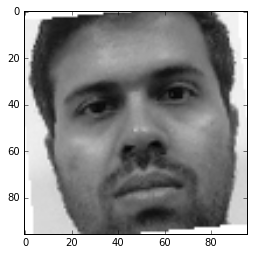

In [65]:
import scipy
plt.imshow(scipy.ndimage.rotate(X_train[13,:,:],angle=5,reshape=False,cval=1),cmap=cm.Greys_r)

In [104]:
import os,sys
from PIL import Image
from skimage.transform import resize

[[70 37 59 59]]
Linear Regression result ['Gopika']
Random Forest Value ['Gopika']


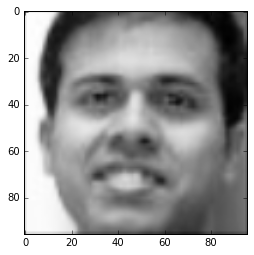

In [106]:
jpgfile = Image.open("/home/mckc/Downloads/1.jpg")
grey = rgb2gray(np.array(jpgfile))
faces  = face_cascade.detectMultiScale(grey.astype(np.uint8),scaleFactor=1.1,minNeighbors=3,minSize=(30, 30))
print faces


for (x,y,w,h) in faces:
    fac = np.array(grey[y:(y+h),x:(x+h)])
    out = resize(fac,(96,96))
    
plt.imshow(out,cmap=cm.Greys_r)

from sklearn.ensemble import RandomForestClassifier
recognizer = RandomForestClassifier(500,verbose=0,oob_score=True,n_jobs=5)
recognizer.fit(X_normal,Y_number)

trial = out.astype(np.float64)
print 'Linear Regression result',map[clf.predict(trial.reshape(-1,9216))]
print 'Random Forest Value',map[recognizer.predict(trial.reshape(-1,9216))]

[[ 44 134 321 321]]
Linear Regression result ['Gopika']
Random Forest Value ['Gopika']


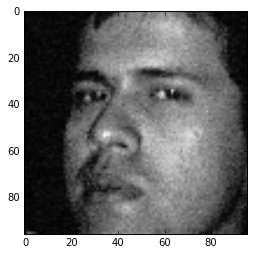

In [108]:
jpgfile = Image.open("/home/mckc/Downloads/2.jpg")
grey = rgb2gray(np.array(jpgfile))
faces  = face_cascade.detectMultiScale(grey.astype(np.uint8),scaleFactor=1.2,minNeighbors=3,minSize=(30, 30))
print faces


for (x,y,w,h) in faces:
    fac = np.array(grey[y:(y+h),x:(x+h)])
    out = resize(fac,(96,96))
    
plt.imshow(out,cmap=cm.Greys_r)

from sklearn.ensemble import RandomForestClassifier
recognizer = RandomForestClassifier(500,verbose=0,oob_score=True,n_jobs=5)
recognizer.fit(X_normal,Y_number)

trial = out.astype(np.float64)
print 'Linear Regression result',map[clf.predict(trial.reshape(-1,9216))]
print 'Random Forest Value',map[recognizer.predict(trial.reshape(-1,9216))]